# Sequential classification
- Sequential classification of a tabular MNIST dataset (Task 3573) using a simple neural network.

In [ ]:

import torch.nn
import torch.optim

import openml_pytorch.config
import openml
import logging
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

In [ ]:
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule

## Define the Model

In [ ]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


## Configure the Data Module

In [ ]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    filename_col="class",
    target_mode="categorical",
)

## Configure the Trainer Module

In [ ]:

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    callbacks=[],
)
openml_pytorch.config.trainer = trainer

## Download the task

In [ ]:
# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

## Run the model on the task

In [ ]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

train: [0.32331635113536156, tensor(0.9008, device='mps:0')]
valid: [0.06406866648840526, tensor(0.9811, device='mps:0')]
Loss tensor(0.0628, device='mps:0')


train: [0.38453052662037035, tensor(0.8769, device='mps:0')]
valid: [0.07353694370814733, tensor(0.9784, device='mps:0')]
Loss tensor(0.2696, device='mps:0')


train: [0.32017667686287477, tensor(0.9007, device='mps:0')]
valid: [0.059844534737723214, tensor(0.9830, device='mps:0')]
Loss tensor(0.1902, device='mps:0')


train: [0.3072006930665785, tensor(0.9049, device='mps:0')]
valid: [0.05989732045975942, tensor(0.9832, device='mps:0')]
Loss tensor(0.1913, device='mps:0')


train: [0.35497158151455027, tensor(0.8902, device='mps:0')]
valid: [0.0839210437593006, tensor(0.9757, device='mps:0')]
Loss tensor(0.2628, device='mps:0')


train: [0.36122630070546735, tensor(0.8852, device='mps:0')]
valid: [0.0754026867094494, tensor(0.9811, device='mps:0')]
Loss tensor(0.0035, device='mps:0')


train: [0.31011446621472666, tensor(0.9039, device='mps:0')]
valid: [0.06878100198412698, tensor(0.9811, device='mps:0')]
Loss tensor(0.0127, device='mps:0')


train: [0.3331792190255732, tensor(0.8969, device='mps:0')]
valid: [0.07425410679408483, tensor(0.9798, device='mps:0')]
Loss tensor(0.0351, device='mps:0')


train: [0.3379972373787478, tensor(0.8956, device='mps:0')]
valid: [0.0701195562453497, tensor(0.9797, device='mps:0')]
Loss tensor(0.1058, device='mps:0')


train: [0.35787033592372136, tensor(0.8865, device='mps:0')]
valid: [0.06584922669425844, tensor(0.9830, device='mps:0')]
Loss tensor(0.2519, device='mps:0')


## View loss

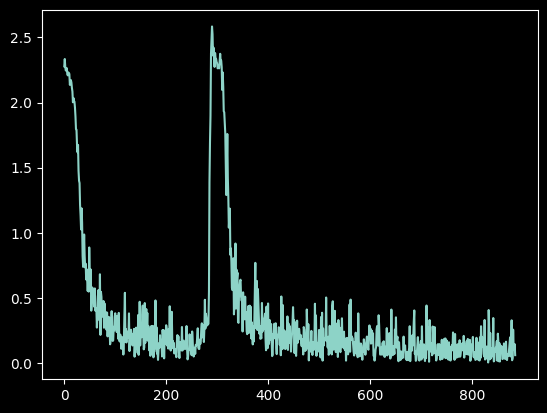

In [ ]:
trainer.runner.cbs[1].plot_loss()

## View learning rate

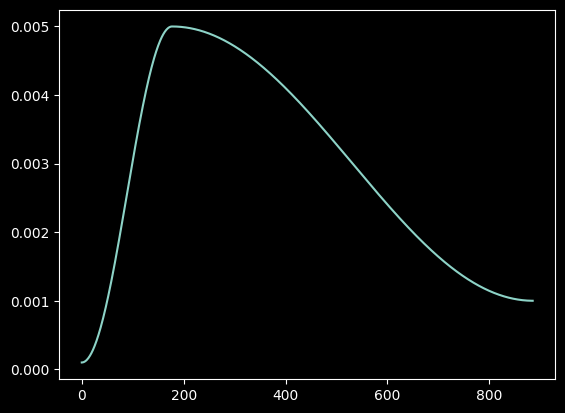

In [ ]:
trainer.runner.cbs[1].plot_lr()

## Publish the run to OpenML

In [ ]:
run.publish()